# Interpretability

In [ ]:
import copy
import time
import itertools

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt  
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


if not torch.cuda.is_available():
    raise Exception("You should enable GPU in the runtime menu.")
device = torch.device("cuda:0")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We will now declare the model we will try to visualize.

**Exercise 1**: Complete the forward method of the model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
        )
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        n = self.conv_layers(x)
        n = torch.flatten(n, start_dim=1)
        n = self.activation(self.fc1(n))
        n = self.fc2(n)
        return n

model = Net()
model.to(device)


Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
t = time.time()
model.train()
epochs = 5
for epoch in range(epochs):  # loop over the dataset multiple times

    for i, (inputs, labels) in enumerate(trainloader):
        # get the inputs to gpu; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 300 == 299:    # print every 300 mini-batches
            print(f"Epoch {epoch+1}/{epochs} [{i+1}/{len(trainloader)}] loss: {loss.item():.2f}")

print('Finished Training')
print(f"Time: {(time.time() - t):.1f}s")

Epoch 1/5 [300/1563] loss: 1.65
Epoch 1/5 [600/1563] loss: 1.55
Epoch 1/5 [900/1563] loss: 1.61
Epoch 1/5 [1200/1563] loss: 1.12
Epoch 1/5 [1500/1563] loss: 1.20
Epoch 2/5 [300/1563] loss: 1.06
Epoch 2/5 [600/1563] loss: 0.93
Epoch 2/5 [900/1563] loss: 1.19
Epoch 2/5 [1200/1563] loss: 0.95
Epoch 2/5 [1500/1563] loss: 0.83
Epoch 3/5 [300/1563] loss: 0.87
Epoch 3/5 [600/1563] loss: 0.96
Epoch 3/5 [900/1563] loss: 1.02
Epoch 3/5 [1200/1563] loss: 1.07
Epoch 3/5 [1500/1563] loss: 0.85
Epoch 4/5 [300/1563] loss: 1.14
Epoch 4/5 [600/1563] loss: 1.20
Epoch 4/5 [900/1563] loss: 0.75
Epoch 4/5 [1200/1563] loss: 1.12
Epoch 4/5 [1500/1563] loss: 0.87
Epoch 5/5 [300/1563] loss: 0.83
Epoch 5/5 [600/1563] loss: 0.97
Epoch 5/5 [900/1563] loss: 0.58
Epoch 5/5 [1200/1563] loss: 0.82
Epoch 5/5 [1500/1563] loss: 0.79
Finished Training
Time: 70.5s


In [ ]:
torch.set_grad_enabled(False)

## Interpretation of the weights

In [ ]:
weights = model.conv_layers[0].weight.cpu()
print(weights.shape)

torch.Size([32, 3, 3, 3])


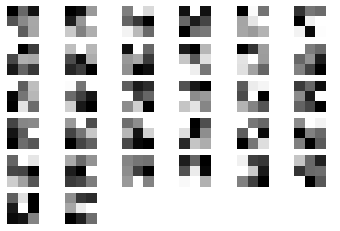

In [ ]:
def display_filters(weights):
    N = int(np.ceil(np.sqrt(weights.shape[0])))
    f, axarr = plt.subplots(N, N)

    p = 0
    for i in range(N):
        for j in range(N):
            # empty plot white when out of kernels to display
            if p >= weights.shape[0]:
                krnl = torch.ones((weights.shape[2], weights.shape[3], 3))
            else:
                if weights.shape[1] == 1: 
                    krnl = weights[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnlplt)
                else:
                    krnl = weights[p,0,:,:]
                    axarr[i, j].imshow(krnl, cmap='gray')
            axarr[i, j].axis('off')
            p += 1
    plt.show()

display_filters(weights)

**Exercise 2:** Is this the shape you expected? What does each number stand for?

**Exercise 3:** Visualize filters in the second convolutional layer.

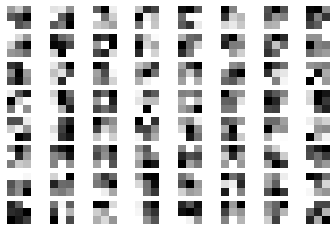

In [ ]:
# TODO: write code here
weights = model.conv_layers[8].weight.cpu()
display_filters(weights)

## Activations

We will create a model that we will use as feature extractor. For that, we need to pick the layer that we want to use.

**Exercise 4:** Complete the Feature Extractor. It should give the output of the first Linear layer (before the corresponding activation function). *Hint*: You can call the layers of the original model by doing `self.model.conv_layers(...)`.

In [ ]:
class Extractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        n = self.model.conv_layers(x)
        n = torch.flatten(n, start_dim=1)
        n = self.model.fc1(n)
        return n

extractor = Extractor(model).to(device).eval()

In [ ]:
feats = []
for images, _ in testloader:
    images = images.to(device)
    feats.append(extractor(images).cpu().numpy())

In [ ]:
feats = np.concatenate(feats)

In [ ]:
feats.shape

(10000, 128)

# Finding the top k samples

In [ ]:
testimages = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified


In [ ]:
K = 10
idxs_top10 = np.argsort(feats, axis=0)[::-1][0:K, :]
picked_samples = np.zeros((K, 128, 32, 32, 3), dtype=float)
for i in range(idxs_top10.shape[0]):
    for j in range(idxs_top10.shape[1]):
        picked_samples[i, j, :, :, :] = np.asarray(testimages[idxs_top10[i, j]][0])/255
picked_samples.shape


(10, 128, 32, 32, 3)

In [ ]:
picked_samples[3, 100].shape

(32, 32, 3)

In [ ]:
units = [10, 11, 12, 13, 14, 15]


In [ ]:
def vis_topk(ims, units):
    f, axarr = plt.subplots(ims.shape[0],ims.shape[1],figsize=(10,10))
    
    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):

            axarr[i,j].imshow(ims[i,j,:,:,:])
            axarr[i,j].axis('off')
            axarr[0,j].set_title('unit '+ str(units[j]))

In [ ]:
picked_images = picked_samples[:, units, :, :].squeeze()

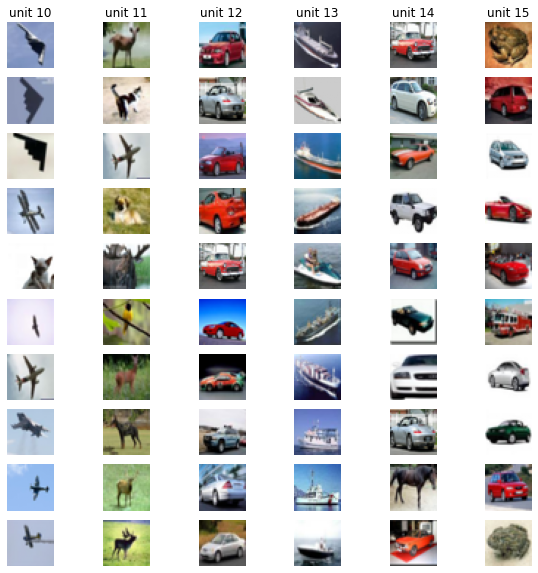

In [ ]:
vis_topk(picked_images, units)

**Exercise 5:** Try different units to display their top K images. Do all units respond to distinguishable concepts? Are there units that respond to similar things?

## Occlusion expermient

In [ ]:
picked_images.shape

(10, 6, 32, 32, 3)

In [ ]:
ims = picked_images


def occ_images(ims, occ=(11, 11), stride=4):
    
    # Reshape to put top images for all units stacked together
    ims = np.rollaxis(ims, 1, 0)
    ims = np.reshape(ims, (ims.shape[0]*ims.shape[1], ims.shape[2], ims.shape[3], ims.shape[4]))
    ims_acc = ims
    
    # slide 
    npos = 1
    st = int(np.floor(occ[0]/2))
    
    # slide occluder, set pixels to 0 and stack to matrix
    for i in range(st, ims.shape[1], stride):
        for j in range(st, ims.shape[2], stride):
            ims_occ = copy.deepcopy(ims)
            ims_occ[:, i-st:i+occ[0]-st, j-st:j+occ[1]-st, :] = 0
            ims_acc = np.vstack((ims_acc, ims_occ))
            npos += 1
            
    return ims_acc

ims_acc = occ_images(ims)
print(ims_acc.shape)

(3000, 32, 32, 3)


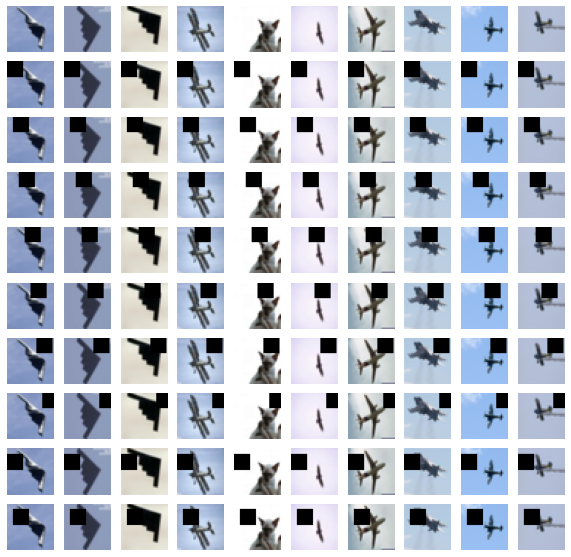

In [ ]:
f, axarr = plt.subplots(10, 10, figsize=(10, 10))
ims_acc_r = ims_acc.reshape(ims_acc.shape[0]//(ims.shape[0]*ims.shape[1]),
                                ims.shape[1], ims.shape[0],
                                ims_acc.shape[1], ims_acc.shape[2], ims_acc.shape[3])
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(ims_acc_r[i,0,j,:,:,:])
        axarr[i,j].axis('off')
plt.show()

In [ ]:
ims_acc_tensor = torch.tensor(ims_acc)
ims_acc_tensor = ims_acc_tensor.permute(0, 3, 1, 2).float().to(device)
ims_acc_tensor.shape

torch.Size([3000, 3, 32, 32])

In [ ]:
features = extractor(ims_acc_tensor)

In [ ]:
features = features.cpu().numpy()

In [ ]:
features.shape

(3000, 128)

In [ ]:
feats_occ = features

In [ ]:
feats_r = np.reshape(feats_occ,(feats_occ.shape[0] // (ims.shape[0] * ims.shape[1]),
                                ims.shape[1], ims.shape[0], feats_occ.shape[1]))

distances = feats_r[0] - feats_r[1:] # original activation minus all the occluded ones
distances = np.rollaxis(distances, 0, 4)

In [ ]:
distances.shape

(6, 10, 128, 49)

Create a mask for plotting

In [ ]:
s = int(np.sqrt(distances.shape[3]))

heatmaps = np.zeros((distances.shape[0],distances.shape[1],distances.shape[3]))
for i in range(len(units)):    
    heatmaps[i] = distances[i,:,units[i],:]
heatmaps.shape

(6, 10, 49)

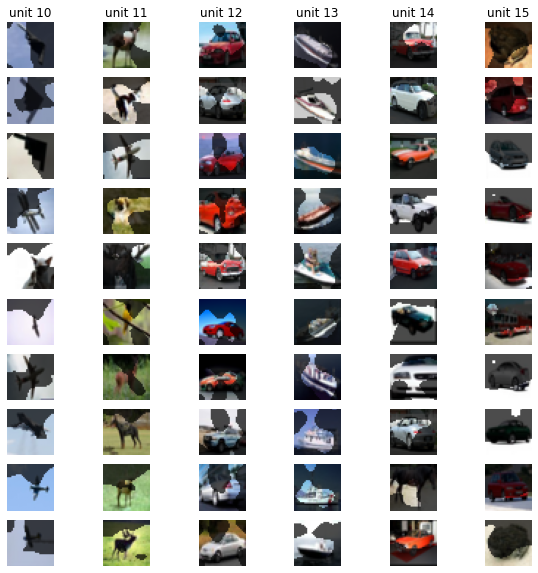

In [ ]:
def vis_occ(ims,heatmaps,units,th=0.5,sig=2):
    
    from scipy.ndimage.interpolation import zoom
    from scipy.ndimage.filters import gaussian_filter
    import copy
    
    ims = np.rollaxis(ims,1,0)
    
    s = int(np.sqrt(heatmaps.shape[2]))
    heatmaps = np.reshape(heatmaps,(heatmaps.shape[0],heatmaps.shape[1],s,s))
    
    f, axarr = plt.subplots(ims.shape[1],ims.shape[0],figsize=(10,10))
    
    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):
            
            im = copy.deepcopy(ims[i,j,:,:,:])
            mask = copy.deepcopy(heatmaps[i,j,:,:])
            if not mask.max() == mask.min():
                # Normalize mask
                mask = (mask - np.min(mask))/(np.max(mask)-np.min(mask))
                # Resize to image size
                mask = zoom(mask,float(im.shape[0])/heatmaps.shape[-1],order=1)
                # Apply gaussian to smooth output
                mask = gaussian_filter(mask,sigma=sig)
                # threshold to obtain mask out of heatmap
                mask[mask>=th] = 1
                mask[mask<th] = 0.3
            else:
                # No heatmap
                mask = zoom(mask,float(im.shape[0])/heatmaps.shape[-1],order=1)
                mask = np.ones_like(mask)*0.3
            
            # Mask all image channels
            for c in range(3):
                im[:,:,c] = im[:,:,c]*mask
                
            axarr[j,i].imshow(im)
            axarr[j,i].axis('off')
            axarr[0,i].set_title('unit '+ str(units[i]))
            
vis_occ(ims,heatmaps,units,th=0.5)

**Exercise 6**: The obtained masks are of course not perfect, but we get to see what parts of the image are most relevant for each unit in the layer. Are these masks what you expected? Do the picked neurons maximally respond to what you have previously guessed? If you see some fully greyed out images, do they correspond to neurons without semantical meaning?

# t-SNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

n = 20
pca = PCA(n_components=20)
pca_features = pca.fit_transform(feats)


In [ ]:
print(feats.shape)
pca_features.shape

(10000, 128)


(10000, 20)

In [ ]:
n_iter = 800
tsne = TSNE(n_components=2, n_iter=n_iter)
tsne_features = tsne.fit_transform(pca_features)


In [ ]:
cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


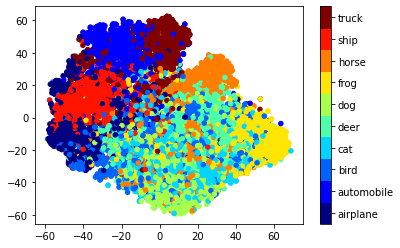

In [ ]:
targets = [t for _, t in testimages]

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=targets, s=20, cmap=plt.cm.get_cmap("jet", 10))
cbar = plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
cbar.ax.set_yticklabels(cifar_labels);

**Exercise 7:** What categories seem to be easier for our model? Which ones are confusing?